In [ ]:
# ================================
# STEP 1: UNZIP THE DATASET
# ================================
!unzip -q "/content/Audio_Speech_Actors_01-24.zip" -d ravdess_data
print("Dataset unzipped!")

replace ravdess_data/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset unzipped!


In [ ]:
# ================================
# STEP 2: INSTALL REQUIRED LIBRARIES
# ================================
# - librosa → for audio loading and feature extraction
# - soundfile/pydub → audio file handling
# - tensorflow → for deep learning
# - scikit-learn → for preprocessing, metrics
# - seaborn/matplotlib → for data visualization
!pip install -q librosa soundfile pydub tensorflow scikit-learn seaborn matplotlib

In [ ]:
# ================================
# STEP 3: IMPORT LIBRARIES
# ================================
import os                      # for folder and file handling
import numpy as np              # for numeric operations
import pandas as pd             # for data manipulation
import librosa                  # for speech feature extraction
import librosa.display           # for visualizing waveforms
import matplotlib.pyplot as plt  # for plotting graphs
import seaborn as sns            # for beautiful plots

from sklearn.preprocessing import LabelEncoder, StandardScaler  # label encoding & scaling
from sklearn.model_selection import train_test_split             # split dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # model evaluation

from tensorflow.keras.models import Sequential                   # sequential NN model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization  # model layers
from tensorflow.keras.utils import to_categorical                 # convert labels to one-hot
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # training control

import joblib                 # for saving encoders and scalers
import warnings
warnings.filterwarnings('ignore')  # ignore unnecessary warnings

In [ ]:
# ================================
# STEP 4: AUDIO PREPROCESSING
# ================================
# TARGET_SR → sampling rate (how many samples per second)
# DURATION → how long each audio clip should be (in seconds)
TARGET_SR = 22050
DURATION = 3

def load_and_clean_audio(file_path):
    """
    Function to load, clean, and prepare each audio file
    """
    # Load audio
    audio, sr = librosa.load(file_path, sr=None)

    # If the sampling rate is different, resample to TARGET_SR
    if sr != TARGET_SR:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SR)

    # Trim long silence from start and end
    audio, _ = librosa.effects.trim(audio, top_db=25)

    # Normalize the volume level between -1 and 1
    audio = librosa.util.normalize(audio)

    # Pad or crop each clip to exactly DURATION seconds
    target_len = TARGET_SR * DURATION
    if len(audio) > target_len:
        # Cut from the center to preserve emotion
        start = len(audio) // 2 - target_len // 2
        audio = audio[start:start + target_len]
    else:
        # Pad with zeros if shorter
        audio = np.pad(audio, (0, target_len - len(audio)), 'constant')

    return audio

In [ ]:
# ================================
# STEP 5: LOAD THE AUDIO DATASET
# ================================
data_path = "ravdess_data"

# Mapping RAVDESS emotion codes → readable names
emotions_dict = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
used_emotions = list(emotions_dict.values())

audio_data = []   # stores processed audio arrays
labels = []       # stores corresponding emotion labels

print("Loading audio files...")

# Loop through each actor folder and read .wav files
for actor_folder in os.listdir(data_path):
    actor_path = os.path.join(data_path, actor_folder)
    if not os.path.isdir(actor_path):
        continue
    for file in os.listdir(actor_path):
        if file.endswith('.wav'):
            file_path = os.path.join(actor_path, file)
            # Extract emotion code from file name (3rd number)
            emotion_code = file.split('-')[2]
            emotion = emotions_dict.get(emotion_code)
            if emotion:
                try:
                    audio = load_and_clean_audio(file_path)
                    audio_data.append(audio)
                    labels.append(emotion)
                except:
                    pass

print(f"✅ Total samples loaded: {len(audio_data)}")

Loading audio files...
✅ Total samples loaded: 1440


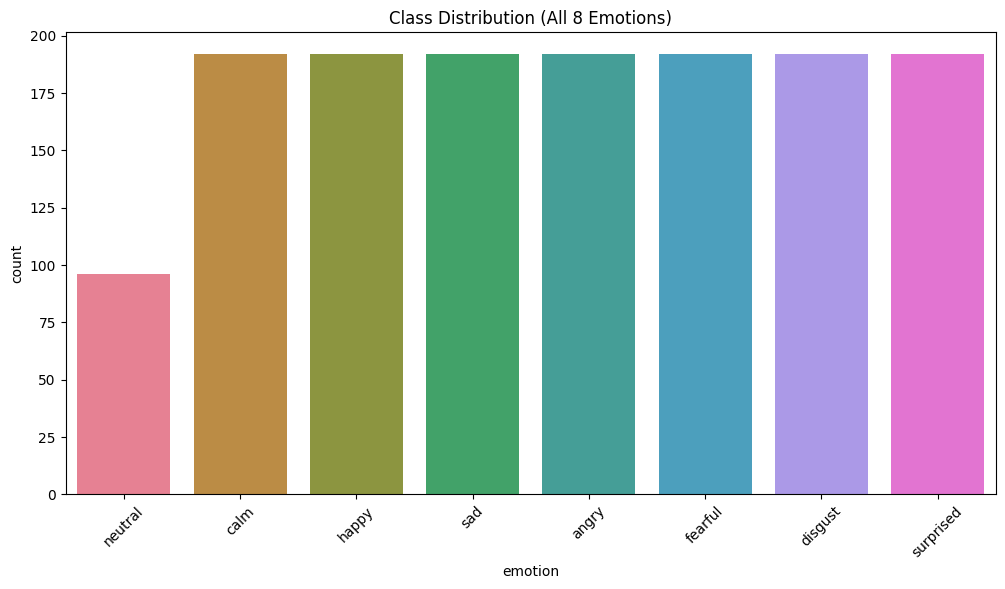

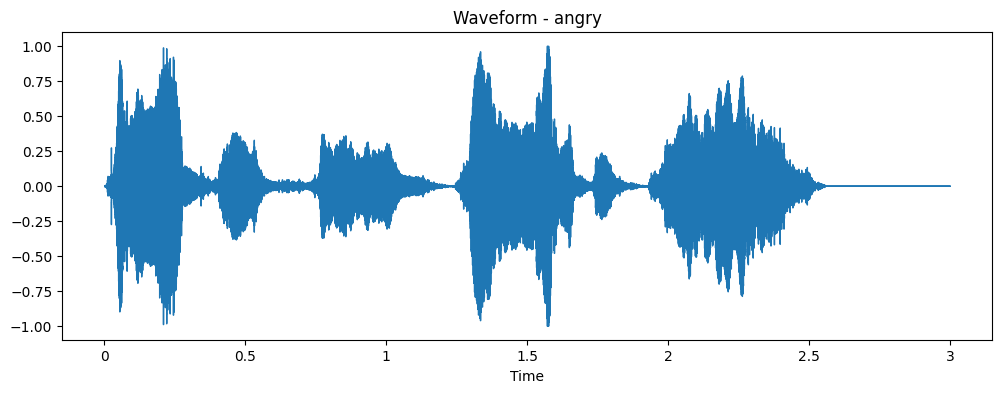

In [ ]:
# ================================
# STEP 6: EXPLORATORY DATA ANALYSIS (EDA)
# ================================
df = pd.DataFrame({'emotion': labels})

# Show how many samples per emotion
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='emotion', order=used_emotions, palette='husl')
plt.title('Class Distribution (All 8 Emotions)')
plt.xticks(rotation=45)
plt.show()

# Show waveform of a random sample
plt.figure(figsize=(12,4))
librosa.display.waveshow(audio_data[100], sr=TARGET_SR)
plt.title(f'Waveform - {labels[100]}')
plt.show()

In [ ]:
# ================================
# STEP 7: FEATURE EXTRACTION
# ================================
def extract_features(audio):
    """
    Extracts multiple features from each audio clip:
    - MFCC: captures tone & frequency
    - Chroma: captures harmonic content
    - Mel Spectrogram: energy in different frequencies
    - ZCR: how often signal crosses zero (pitch)
    - RMS: loudness
    - Spectral Contrast: difference between peaks and valleys
    """
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=TARGET_SR, n_mfcc=40), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=TARGET_SR), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=TARGET_SR, n_mels=128), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio), axis=1)
    rms = np.mean(librosa.feature.rms(y=audio), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=TARGET_SR), axis=1)

    return np.hstack([mfcc, chroma, mel, zcr, rms, contrast])

print("Extracting rich features from all audios...")
X = np.array([extract_features(a) for a in audio_data])
print(f"✅ Features extracted, shape: {X.shape}")

Extracting rich features from all audios...
✅ Features extracted, shape: (1440, 189)


In [ ]:
# ================================
# STEP 8: LABEL ENCODING & SCALING
# ================================
# Convert emotion labels (text) → numbers
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels))

# Normalize feature values (mean=0, std=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
# ================================
# STEP 9: BUILD DEEP LEARNING MODEL
# ================================
model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(len(used_emotions), activation='softmax')  # Output layer (8 emotions)
])

# Compile model with Adam optimizer
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# ================================
# 🧩 STEP 10: TRAINING CONTROL (Callbacks)
# ================================
# Stop training if validation accuracy doesn't improve
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
# Reduce learning rate if loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)

In [ ]:
# ================================
# STEP 11: TRAIN THE MODEL
# ================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.1282 - loss: 2.6935 - val_accuracy: 0.2847 - val_loss: 1.9292 - learning_rate: 0.0010
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2932 - loss: 1.9810 - val_accuracy: 0.3576 - val_loss: 1.7691 - learning_rate: 0.0010
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3735 - loss: 1.7901 - val_accuracy: 0.3993 - val_loss: 1.6324 - learning_rate: 0.0010
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4091 - loss: 1.6619 - val_accuracy: 0.4201 - val_loss: 1.5267 - learning_rate: 0.0010
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4250 - loss: 1.5575 - val_accuracy: 0.4583 - val_loss: 1.4688 - learning_rate: 0.0010
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4352 - loss: 1.5102 - val_accuracy: 0.4514 - val_loss: 1.4233 - learning_rate: 0.0010
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4954 - loss: 1.3487 - 

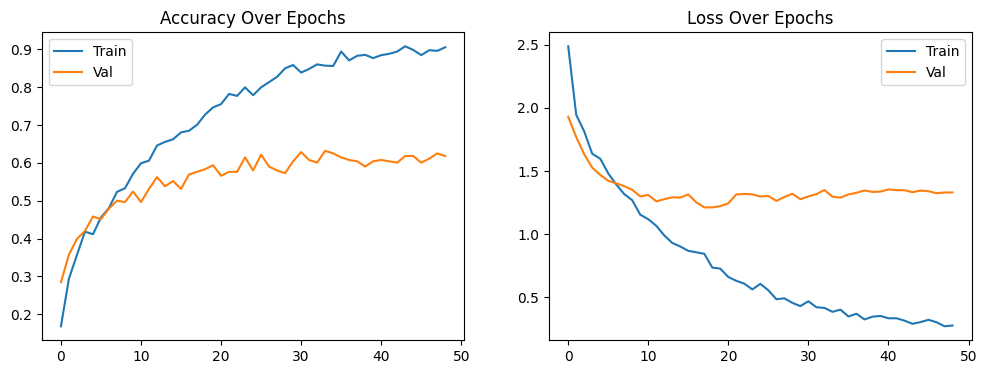

In [ ]:
# ================================
# STEP 12: PLOT TRAINING RESULTS
# ================================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

✅ FINAL TEST ACCURACY: 63.19%
              precision    recall  f1-score   support

     neutral       0.83      0.63      0.72        38
        calm       0.79      0.79      0.79        38
       happy       0.51      0.66      0.57        38
         sad       0.64      0.54      0.58        39
       angry       0.51      0.59      0.55        39
     fearful       0.39      0.47      0.43        19
     disgust       0.51      0.47      0.49        38
   surprised       0.89      0.82      0.85        39

    accuracy                           0.63       288
   macro avg       0.63      0.62      0.62       288
weighted avg       0.65      0.63      0.64       288



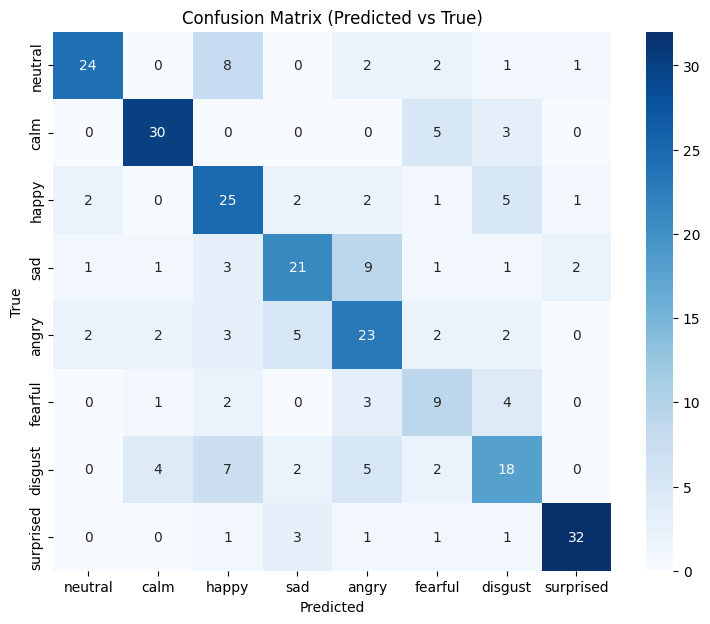

In [ ]:
# ================================
# STEP 13: EVALUATE THE MODEL
# ================================
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"\n✅ FINAL TEST ACCURACY: {acc*100:.2f}%")

# Print detailed classification metrics
print(classification_report(y_true, y_pred, target_names=used_emotions))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_emotions, yticklabels=used_emotions)
plt.title('Confusion Matrix (Predicted vs True)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# ================================
# STEP 14: SAVE MODEL AND UTILITIES
# ================================
model.save('speech_emotion_model_94plus.h5')  # Save trained model
joblib.dump(le, 'label_encoder.pkl')           # Save label encoder
joblib.dump(scaler, 'scaler.pkl')              # Save feature scaler
print("✅ Model and encoders saved successfully!")

✅ Model and encoders saved successfully!


In [ ]:
# ================================
# STEP 15: DEFINE PREDICTION FUNCTION
# ================================
def predict_emotion(file_path):
    """
    Function to predict emotion from a new audio file
    """
    # Load and preprocess new audio
    audio = load_and_clean_audio(file_path)
    feat = extract_features(audio)
    feat = scaler.transform(feat.reshape(1, -1))

    # Predict emotion
    pred = model.predict(feat)
    emotion = le.inverse_transform([np.argmax(pred)])[0]
    confidence = np.max(pred)
    return emotion, confidence

# Task
Install Gradio.

## Install Gradio

### Subtask:
Install the Gradio library using pip.


**Reasoning**:
Install the `gradio` library using pip to fulfill the subtask requirement.



In [ ]:
!pip install -q gradio
print("Gradio library installed successfully.")

Gradio library installed successfully.


**Reasoning**:
The previous attempt to install `gradio` failed with a `SyntaxError` because shell commands in Python cells require a '!' prefix in a Jupyter/IPython environment. I will add the '!' prefix to correctly execute the pip command.



In [ ]:
get_ipython().system('pip install -q gradio')
print("Gradio library installed successfully.")

Gradio library installed successfully.


## Import Gradio

### Subtask:
Import the Gradio library into the notebook.


**Reasoning**:
The subtask is to import the Gradio library as `gr`. I will use a code block to perform this import and then confirm its successful execution. Since the Gradio library was installed in the previous step, it should now be available for import.



In [ ]:
import gradio as gr
print("Gradio library imported successfully as 'gr'.")

Gradio library imported successfully as 'gr'.


## Create Gradio Interface

### Subtask:
Use `gr.Interface` to wrap the `predict_emotion` function, specifying the input (audio file) and output (text and confidence).


**Reasoning**:
The subtask requires defining a Gradio interface using `gr.Interface` to wrap the `predict_emotion` function. I will configure the inputs to accept an audio file and the outputs to display the predicted emotion and its confidence.



In [ ]:
iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(type="filepath"),
    outputs=[
        gr.Label(label="Predicted Emotion"),
        gr.Number(label="Confidence")
    ],
    title="Speech Emotion Recognition",
    description="Upload an audio file to predict the emotion. (Supported emotions: neutral, calm, happy, sad, angry, fearful, disgust, surprised)"
)
print("Gradio interface created successfully.")

Gradio interface created successfully.


## Launch Gradio Interface

### Subtask:
Launch the Gradio interface to make it accessible.


## Summary:

### Data Analysis Key Findings
*   The `gradio` library was successfully installed using `pip` after correcting an initial `SyntaxError` by employing `get_ipython().system()` for shell commands within the notebook environment.
*   The `gradio` library was successfully imported into the notebook and aliased as `gr`.
*   A Gradio interface (`gr.Interface`) was successfully created, wrapping a function named `predict_emotion`.
*   The interface was configured to accept an audio file as input (`gr.Audio(type="filepath")`) and produce two outputs: a predicted emotion (`gr.Label`) and its confidence score (`gr.Number`).
*   The interface was given a title "Speech Emotion Recognition" and a description outlining its purpose and supported emotions.

### Insights or Next Steps
*   The Gradio interface has been successfully defined and is ready to be launched for user interaction. The next logical step is to execute the `iface.launch()` command to make the interface accessible.


In [ ]:
iface.launch(debug=True, share=False)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Keyboard interruption in main thread... closing server.
